# Introduction

This lab will explore the Steiner tree problem, examining heuristics as well as optimal solution methods.

First, import required packages.

In [235]:
import networkx as nx
import itertools
import matplotlib.pyplot as plt
import treeopt
import numpy as np
from scipy.spatial import Delaunay

from networkx.algorithms import approximation

import gurobipy as gp
from gurobipy import GRB

# Generating a Random Graph

Next, set some parameters related to how we will construct the graph.

In [236]:
num_vertices = 25
num_terminals = 7
distance_max = 0.55
np.random.seed(41)

To ensure that the solutions to the Steiner Tree Problem are not trivial, I manually added edges and manually changed some edge weights.

In [237]:
edges_to_add = [(3,6), (22,23)] #[(1,9)]
weights_to_change = {} #{(16,10) : 7, (0,1) : 6, (9,10) : 7, (1,9) : 12}

Next, we randomly generate points and use the Delaunay triangulation to ensure that the graph is *planar* (i.e., the edges to not cross over each other).

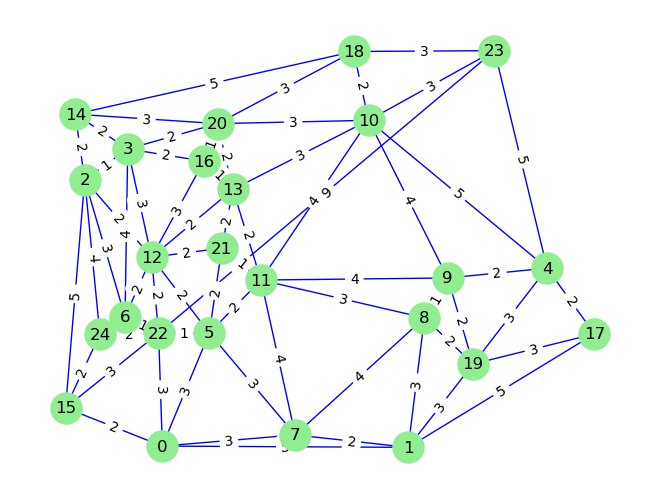

In [238]:
points = np.random.rand(num_vertices, 2)

# Compute the Delaunay triangulation of these points
tri = Delaunay(points)

G = nx.Graph()
G.add_nodes_from(range(num_vertices))

for i in range(num_vertices):
    G.nodes[i]['pos'] = points[i]

# For every triangle (simplex), add edges between its vertices
for simplex in tri.simplices:
    for i in range(len(simplex)):
        for j in range(i + 1, len(simplex)):
            u, v = simplex[i], simplex[j]
            distance = 1 + 10*np.linalg.norm(points[u] - points[v])
            G.add_edge(u, v, weight=int(distance))


# Remove some edges that have a distance longer than distance_max
for edge in list(G.edges()):
    distance = np.linalg.norm(points[edge[0]] - points[edge[1]])
    if distance > distance_max:
        G.remove_edge(*edge)

for (i,j) in edges_to_add:
    distance = 1 + 10*np.linalg.norm(points[i] - points[j])
    G.add_edge(i,j, weight=int(distance))

for edge in weights_to_change:
    if G.has_edge(*edge):
        G[edge[0]][edge[1]]['weight'] = weights_to_change[edge]
        
pos = {i: G.nodes[i]['pos'] for i in G.nodes()}

nx.draw(G, pos, with_labels=True, node_color='lightgreen', edge_color='blue', node_size=500)

edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

plt.show()

This code writes this graph as a LaTeX ``tikzpicture``.

In [239]:
treeopt.graph_to_latex(G, scale = 10, edge_labels = edge_labels, tikz_file_name = "graph15.tex")

# Minimum Steiner Tree Problem

Next we will turn to the Minimum Steiner Tree Problem. The following code randomly selects some of the vertices to be terminals. Thus, the remaining vertices are *Steiner vertices*.

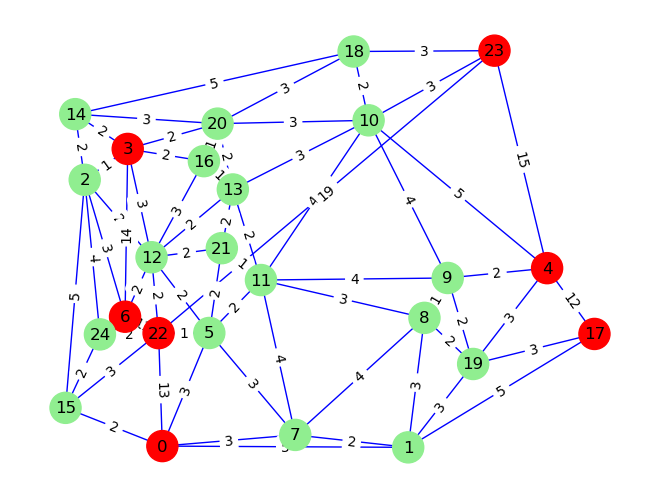

In [240]:
# sample a set of 5 terminal vertices
terminals = np.random.choice(num_vertices, size=num_terminals, replace=False)

for i in range(num_terminals):
    for j in range(i + 1, num_terminals):
        t1 = terminals[i]
        t2 = terminals[j]
        if G.has_edge(t1, t2):
            G[t1][t2]['weight'] += 10

# Set the color of terminal vertices to a different color
node_colors = ['lightgreen' if i not in terminals else 'red' for i in range(num_vertices)]

# Draw the graph with terminal vertices labeled in red
nx.draw(G, pos, with_labels=True, node_color=node_colors, edge_color='blue', node_size=500)

edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

plt.show()

Again, we export the graph to LaTeX.

In [241]:
def get_node_style(i):
    if i in terminals:
        return "terminal_style"
    else:
        return "node_style"

node_opts = {i: get_node_style(i) for i in G.nodes()}
treeopt.graph_to_latex(G, scale = 10, edge_labels = edge_labels, node_opts = node_opts, 
                       tikz_file_name = "terminals15.tex")

# Problems

The following problems relate to finding a Steiner tree solution for the randomly generated graph above (with the randomly selected terminals).

## Problem 1
Do the following

a. Write code that finds the minimum spanning tree on the terminal subgraph (the subgraph of G induced by only the terminal vertices).

b. Compare the solution computed by your algorithm with the optimal solution (you may use Gurobi to find the optimal solution).

## Part a

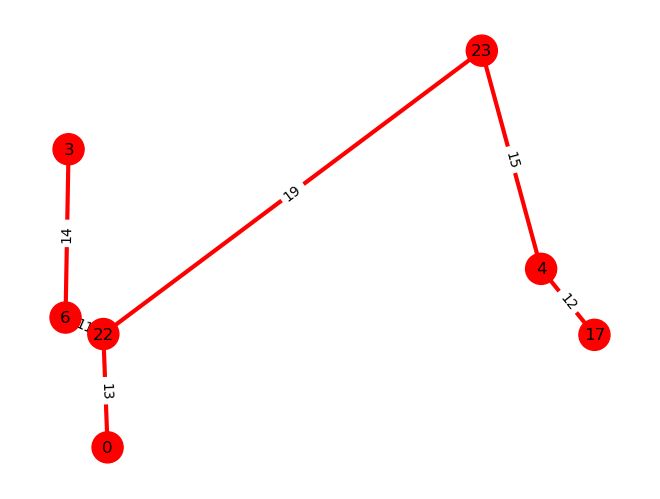

In [242]:
# Create a new graph with only the terminal vertices
terminal_subgraph = nx.subgraph(G, terminals)
mst_terminal_subgraph = nx.minimum_spanning_tree(terminal_subgraph)

node_colors_terminal_sub = ['lightgreen' if i not in terminals else 'red' 
                            for i in terminal_subgraph.nodes()]
treeopt.display_steiner_solution(terminal_subgraph, mst_terminal_subgraph, 
                                 node_colors_terminal_sub)

edge_opts = {e: treeopt.get_edge_style(e, mst_terminal_subgraph.edges()) 
             for e in terminal_subgraph.edges}
node_opts = {i: "terminal_style" for i in terminal_subgraph.nodes()}

treeopt.graph_to_latex(terminal_subgraph, scale = 10, edge_labels = edge_labels, 
                       edge_opts = edge_opts, node_opts = node_opts, 
                       tikz_file_name = "terminal-subgraph.tex")

In [243]:
total_weight = sum(G[u][v]['weight'] for u, v in terminal_subgraph.edges())
print(f'Total weight of the Steiner tree: {total_weight}')

Total weight of the Steiner tree: 84


## Part b

Objective value: 30.0


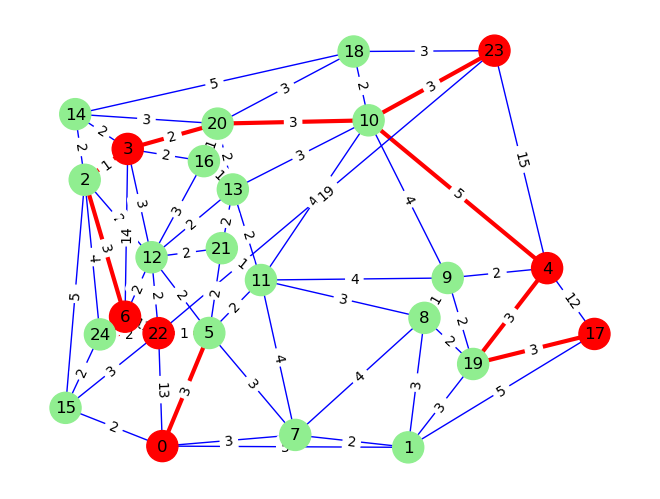

In [244]:
model = gp.Model("Steiner_Tree")
diGraph = treeopt.get_digraph(G)
arcs = diGraph.edges()

x = model.addVars(G.edges(), vtype=GRB.BINARY, name="x")

y = model.addVars(arcs, terminals[1:], vtype=GRB.CONTINUOUS, name="y")

model.setObjective(gp.quicksum(G[u][v]['weight']*x[u,v] for u,v in G.edges()), GRB.MINIMIZE)

root = terminals[0]

def get_net_flow_rhs(i, k, root):
    if i == root:
        return 1
    elif i == k:
        return -1
    else:
        return 0

# flow balance constraints
for k in terminals[1:]:
    for i in G.nodes():
        outflow = gp.quicksum(y[i,j,k] for i,j in diGraph.out_edges(i))
        inflow = gp.quicksum(y[j,i,k] for j,i in diGraph.in_edges(i))
        model.addConstr(outflow - inflow == get_net_flow_rhs(i,k,root), name=f"flow_balance_{i}_{k}")

model.addConstrs(y[i,j,k] <= x[i,j] for (i,j) in G.edges() for k in terminals[1:])
model.addConstrs(y[j,i,k] <= x[i,j] for (i,j) in G.edges() for k in terminals[1:])

model.setParam('OutputFlag', 0)
model.optimize()

print("Objective value:", model.ObjVal)

steiner_tree_edges = [(u, v) for u, v in G.edges() if x[u, v].x > 0.5]

for u, v in G.edges():
    if (u, v) in steiner_tree_edges:
        G[u][v]['color'] = 'red'
        G[u][v]['width'] = 3.0
    else:
        G[u][v]['color'] = 'blue'
        G[u][v]['width'] = 1.0

edge_colors = ['red' if G[u][v].get('color') == 'red' else 'blue' for u, v in G.edges()]
widths = [G[u][v]['width'] for u, v in G.edges()]

nx.draw(G, pos, with_labels=True, node_color=node_colors, edge_color=edge_colors, width=widths, node_size=500)

edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

plt.show()

edge_opts = {e: treeopt.get_edge_style(e, steiner_tree_edges) for e in G.edges}
node_opts = {i: get_node_style(i) for i in G.nodes()}

treeopt.graph_to_latex(G, scale = 10, edge_labels = edge_labels, node_opts = node_opts, 
                       edge_opts = edge_opts, tikz_file_name = "steiner-opt-15.tex")

We observe that the optimal objective value (30) is much higher than the total weight of the spanning tree of the terminal subgraph.

## Problem 2
Do the following

a. Implement the algorithm of Kuo et al (i.e., finding the MST for the metric closure).

b. Compare the solution computed by your algorithm with the optimal solution (you may use Gurobi to find the optimal solution).

## Part a

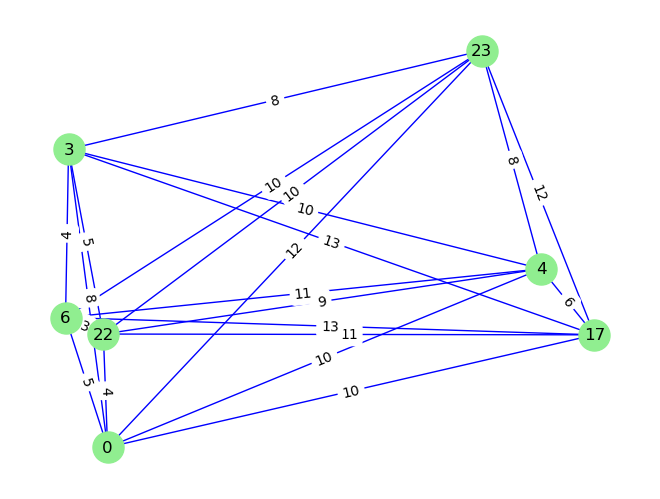

In [245]:
diGraph = treeopt.get_digraph(G)
shortest_paths = dict(nx.all_pairs_dijkstra_path(G, weight = "weight"))

metric_closure_graph = nx.Graph()
metric_closure_graph.add_nodes_from(terminals)

for i in terminals:
    metric_closure_graph.nodes[i]['pos'] = points[i]
    
# Add edges between the terminal vertices from the original graph
for u, v in itertools.combinations(terminals, 2):
    if u != v:
        path = shortest_paths[u][v]
        distance_of_path = sum(G[u][v]['weight'] for u, v in zip(path[:-1], path[1:]))
        metric_closure_graph.add_edge(u, v, weight=distance_of_path)

# Draw the subgraph with only the terminal vertices
nx.draw(metric_closure_graph, pos, with_labels=True, node_color='lightgreen', edge_color='blue', node_size=500)

edge_labels = nx.get_edge_attributes(metric_closure_graph, 'weight')
nx.draw_networkx_edge_labels(metric_closure_graph, pos, edge_labels=edge_labels)

plt.show()

node_opts = {i: "terminal_style" for i in metric_closure_graph.nodes()}

treeopt.graph_to_latex(metric_closure_graph, scale = 10, edge_labels = edge_labels, 
                        node_opts = node_opts, tikz_file_name = "metric-closure.tex")

Total weight of the minimum spanning tree: 33


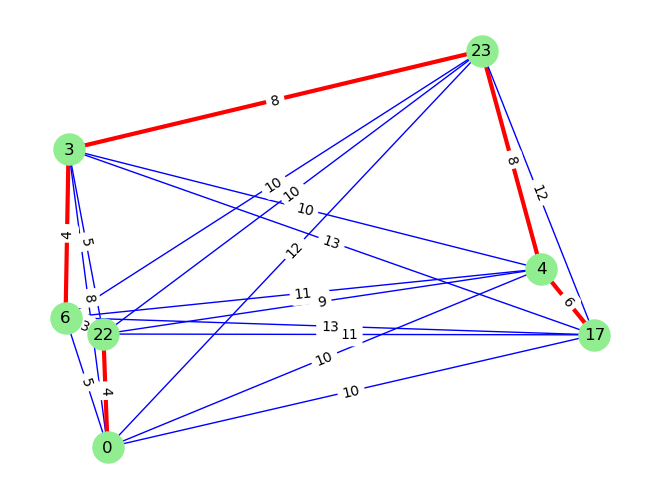

In [246]:
mst = nx.minimum_spanning_tree(metric_closure_graph)

spanning_tree_weight = sum(metric_closure_graph[u][v]['weight'] for u, v in mst.edges())
print(f'Total weight of the minimum spanning tree: {spanning_tree_weight}')

for u, v in metric_closure_graph.edges():
    if (u,v) in mst.edges():
        metric_closure_graph[u][v]['color'] = 'red'
        metric_closure_graph[u][v]['width'] = 3.0
    else:
        metric_closure_graph[u][v]['color'] = 'blue'
        metric_closure_graph[u][v]['width'] = 1.0

edge_colors = ['red' if metric_closure_graph[u][v].get('color') == 'red' else 'blue' for u, v in metric_closure_graph.edges()]
widths = [metric_closure_graph[u][v]['width'] for u, v in metric_closure_graph.edges()]

# Draw the graph with MST edges in red and thicker
nx.draw(metric_closure_graph, pos, with_labels=True, node_color='lightgreen', edge_color=edge_colors, width = widths, node_size=500)

edge_labels = nx.get_edge_attributes(metric_closure_graph, 'weight')
nx.draw_networkx_edge_labels(metric_closure_graph, pos, edge_labels=edge_labels)

plt.show()

## Part b

We observe that the weight of the optimal spanning tree (33) is slightly higher than the optimal weight.

## Problem 3
Do the following

a. Implement the shortest path addition heuristic discussed in class.

b. Compare the solution computed by your algorithm with the optimal solution (you may use Gurobi to find the optimal solution).

## Part a

In [247]:
def get_shortest_distance_and_path(unvisited : list, T : nx.Graph):
    shortest_length = float('inf')
    shortest_path = None
    for t in unvisited:
        paths = nx.shortest_path(G, source=t, weight = "weight")
        filtered_paths = [v for k, v in paths.items() if k in T.nodes() and k != t]
        for path in filtered_paths:
            path_length = sum(G[u][v]['weight'] for u, v in zip(path[:-1], path[1:]))
            if path_length < shortest_length:
                shortest_length = path_length
                shortest_path = path
    return shortest_path
    
u = terminals[0]
T = nx.Graph()
T.add_node(u)
unvisited = [i for i in terminals if i != u]
while unvisited:
    path = get_shortest_distance_and_path(unvisited, T)
    for i in range(len(path) - 1):
        u, v = path[i], path[i + 1]
        if not T.has_edge(u, v):
            T.add_edge(u, v, weight=G[u][v]['weight'])
        if not T.has_node(u):
            T.add_node(u)
        if not T.has_node(v):
            T.add_node(v)
    unvisited.remove(path[0])

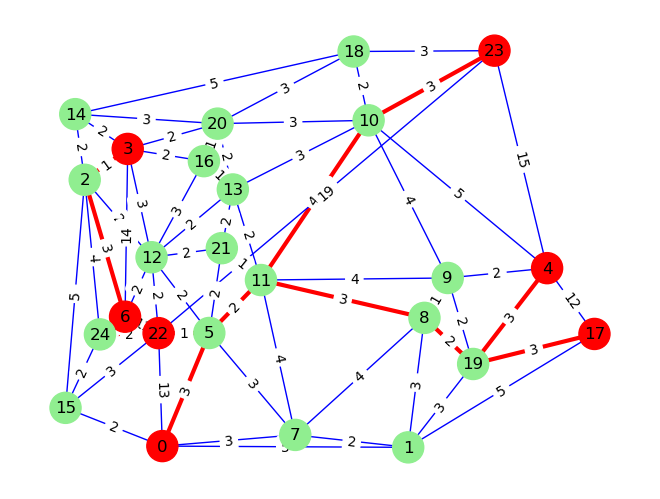

In [248]:
steiner_tree_edges = T.edges()

for u, v in G.edges():
    if (u, v) in steiner_tree_edges:
        G[u][v]['color'] = 'red'
        G[u][v]['width'] = 3.0
    else:
        G[u][v]['color'] = 'blue'
        G[u][v]['width'] = 1.0

edge_colors = ['red' if G[u][v].get('color') == 'red' else 'blue' for u, v in G.edges()]
widths = [G[u][v]['width'] for u, v in G.edges()]

nx.draw(G, pos, with_labels=True, node_color=node_colors, edge_color=edge_colors, width=widths, node_size=500)

edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

plt.show()

edge_opts = {e: treeopt.get_edge_style(e, steiner_tree_edges) for e in G.edges}
node_opts = {i: get_node_style(i) for i in G.nodes()}

treeopt.graph_to_latex(G, scale = 10, edge_labels = edge_labels, node_opts = node_opts, 
                       edge_opts = edge_opts)

## Part b

In [249]:
spanning_tree_weight = sum(G[u][v]['weight'] for u, v in T.edges())
print(f'Total weight of the minimum spanning tree: {spanning_tree_weight}')

Total weight of the minimum spanning tree: 31


We observe that the total weight of the spanning tree is slightly higher than the optimal weight.